Decision Tree Modeling — Feature Selection and Predictive Analysis

Objective

This notebook explores tree-based models (Decision Tree, Random Forest, XGBoost, LightGBM) to:

1. Model short-term revenue growth (rev_growth_t+1) for IT and AI sector companies.
2. Rank feature importance to identify which financial variables most strongly influence next-year revenue growth.
3. Generate interpretable insights that feed into more advanced machine learning models and integrate with the Monte Carlo–enhanced DCF valuation.

1. Decision Trees: Core Idea

A decision tree for regression predicts a continuous target by splitting the dataset into increasingly homogeneous subsets based on the feature values.

Split criterion: Features are chosen to minimize the Sum of Squared Errors (SSE) after the split.
- Initial prediction: the mean of all observations (dummy prediction);
- SSE: the sum of squared deviations from this mean;
- The split that produces the largest SSE reduction is selected.
Goal: End with “pure” terminal nodes (leaves) where the target values are as homogeneous as possible.

2. Key Differences from Linear Regression
- Decision trees do not estimate coefficients for predictors; instead, they find optimal split points for each feature.;
- Continuous targets aim for minimal variance (low deviance) within each leaf.
- Categorical targets aim for leaves where most or all observations belong to the same class.

3. Overfitting Considerations
- If a tree is allowed to grow without constraints, it will eventually have one leaf per observation — perfect training accuracy but poor generalization;
- Control mechanisms:
  - max_depth (limits tree height);
  - min_samples_split / min_samples_leaf;
  - max_leaf_nodes;
  - Cost-complexity pruning (ccp_alpha).

4. Symmetry in Trees
- Learned decision trees are not inherently symmetric.
- Limiting max_depth does not force symmetry — it only caps the longest root-to-leaf path;
- True “balanced trees” (AVL, Red–Black) are a data structure concept, not a property of learned models.

5. Impact of Outliers

- Outliers can disproportionately influence split points, potentially leading to less generalizable models;
- This effect depends on whether the outlier appears in the training or validation set.

6. Why Tree Models for Feature Importance
- Tree-based models provide a natural ranking of features based on their contribution to variance reduction;
- This ranking helps pre-select variables for advanced models like XGBoost or LightGBM, improving performance and reducing noise.

7. Pipeline in This Notebook
- Train a Decision Tree Regressor on the financial dataset.
- Evaluate model performance using R² and MSE on train/test splits.
- Extract feature importance rankings.
- Extend to Random Forest, XGBoost, and LightGBM for improved predictive accuracy.
- Prepare feature rankings for integration into the Monte Carlo–DCF pipeline.

In [1]:
import os
import pandas as pd
import numpy as np
from typing import Dict
from tqdm import tqdm
import random
import csv
import statistics
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load pre-encoded training and test datasets (categorical variables already encoded)

with open("outputs/df_companies_train_test_encoded_CLEANED.pkl", "rb") as f: # rb = read in a binary mode
   companies_train_encoded = pickle.load(f)
   companies_test_encoded = pickle.load(f)

companies_test_encoded.head() 

,revenue,netincome,r&d,sg&a,ebit,revenuegrowth,ebitmargin,netmargin,rd_to_revenue,sga_to_revenue,...,UMCSENT,negative_equity_flag,label_Cloud & Data,label_Collab & CX SaaS,label_Consumer SaaS,label_Enterprise SaaS,label_Mature Pivots,label_Mega‑Cap Tech,label_Vertical SaaS,revenuegrowth_t+1
346,5.859440e+08,-452551000.0,264041000.0,5.821620e+08,-462674000.0,0.510694,-0.789622,-0.772345,0.450625,0.993545,...,58.975000,False,1,0,0,0,0,0,0,0.325983
378,2.065659e+09,-797526000.0,788058000.0,1.402328e+09,-842267000.0,0.694098,-0.407747,-0.386088,0.381504,0.678877,...,58.975000,False,1,0,0,0,0,0,0,0.358641
293,8.743320e+08,-41459000.0,218523000.0,4.339510e+08,-27626000.0,0.134362,-0.031597,-0.047418,0.249931,0.496323,...,77.616667,True,0,0,0,1,0,0,0,0.133293
324,5.722210e+08,-43429000.0,185863000.0,2.528510e+08,-23836000.0,0.075242,-0.041655,-0.075896,0.324810,0.441876,...,58.975000,False,0,0,0,0,0,0,1,0.070742
179,8.360330e+08,242317000.0,166654000.0,3.463590e+08,144208000.0,0.264689,0.172491,0.289841,0.199339,0.414289,...,81.541667,False,0,0,0,1,0,0,0,0.431124


In [3]:
TargetName = "revenuegrowth_t+1"
FeaturesNames = companies_train_encoded.columns.drop(TargetName)

X_train = companies_train_encoded.drop(['revenuegrowth_t+1'], axis = 1)
y_train = companies_train_encoded['revenuegrowth_t+1']

X_test = companies_test_encoded.drop(['revenuegrowth_t+1'], axis = 1)
y_test = companies_test_encoded['revenuegrowth_t+1']

In [4]:
# Simple function to assess the decision tree model prediction scores

def evaluate_regression(y_true, y_pred) -> Dict[str, float]:
    """
    Compute common regression quality metrics with a MAPE that safely
    handles zeros/small values in the denominator.

    Parameters
    ----------
    y_true : array-like
        Ground-truth targets for the holdout set.
    y_pred : array-like
        Model predictions for the holdout set.

    Returns
    -------
    Dict[str, float]
        Dictionary with MAE, RMSE, MAPE_% and R2.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    eps = 1e-8
    # denom is a “safe” version of y_true where no element is exactly zero or too close to zero.
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape, "R2": r2}

In [5]:
# Define the parameter grid for the single Decision Tree
# Decision Tree

# Define parameter grid for a single Decision Tree

RANDOM_STATE = 42

param_grid = {
    'max_depth': [3, 5, 7, 10, None],          # tree depth limit
    # Be carefull, because too small dataset, and too small  'min_samples_split', 'min_samples_leaf' paramateers
    # we can get too small number if samples in leave too truly believe in the accuarate predictions ontest data
    'min_samples_split':[10, 20],        # min samples to split
    'min_samples_leaf': [10, 12, 14, 17, 20, 22, 24], # [1, 2, 5],          # min samples per leaf
    'max_features': [None, 'sqrt', 'log2'], # number of features to consider
}

# “shuffle” is used to randomly mix up the rows of the dataset before splitting them into folds.
# Without shuffle (default in KFold):
# The data is split in the original order.
# If the rows are sorted by time, company, industry, or any pattern, each fold will contain only certain types of data.
# That often produces optimistic or pessimistic CV scores and bad generalization, because the model trains and tests on very different distributions.
# With shuffle (shuffle=True):
# The order of the samples is randomized first, then split into folds.
# Each fold is more representative of the whole dataset → the CV performance is a better predictor of holdout performance.
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Create model
tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

# GridSearchCV setup
grid = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',  # main metric for search
    n_jobs=-1,
    verbose=1
)

print("\n[Train] GridSearchCV on DecisionTreeRegressor (score = neg MSE)")
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV RMSE:", (-grid.best_score_)**0.5)

# Best model
best_tree = grid.best_estimator_

# Predictions on holdout set
y_pred_test = best_tree.predict(X_test)

# Evaluate using the evaluate function but print like RandomForest
test_scores = evaluate_regression(y_test, y_pred_test)
print("Test MAE :", test_scores["MAE"])
print("Test RMSE:", test_scores["RMSE"])
print("Test MAPE:", test_scores["MAPE_%"])
print("Test R²  :", test_scores["R2"])


[Train] GridSearchCV on DecisionTreeRegressor (score = neg MSE)
Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best CV RMSE: 0.23680164072988008
Test MAE : 0.09669798298358667
Test RMSE: 0.15378972335007435
Test MAPE: 276.16962345930637
Test R²  : 0.48485651024545906


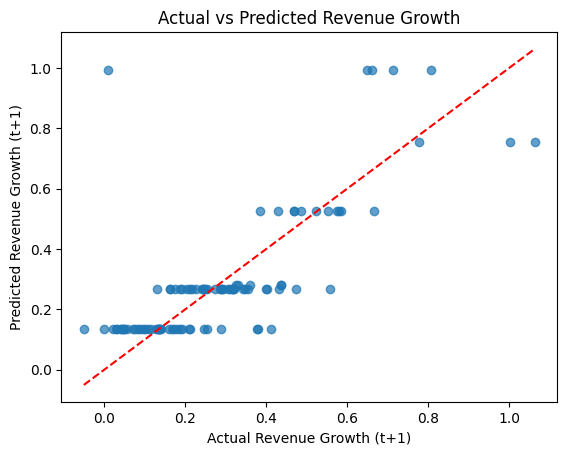

In [6]:
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.xlabel('Actual Revenue Growth (t+1)')
plt.ylabel('Predicted Revenue Growth (t+1)')
plt.title('Actual vs Predicted Revenue Growth')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.show()

At first I didn't use shuffle, so I got negative R_2. My dataset is ordered by years, so shuffled option is necessary in this case to better generalize the prediction.

In [5]:
# Random Forest

RANDOM_STATE = 42

rf_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, bootstrap=True, oob_score=False))
])

rf_param_grid = {
    "rf__n_estimators": [400, 800, 1200],        # more trees = more stable
    "rf__max_depth": [None, 10, 20, 30],         # cap depth to reduce variance
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 5],           # VERY important for variance control
    # In a random forest:
    # When a tree node needs to split, it doesn’t consider all available features.
    # Instead, it considers a random subset of features, and chooses the best split among them.
    # max_features tells the model how big that subset can be.
    # "sqrt" → use √(n_features) features at each split (default for classification, but often works well for regression too).
    # "log2" → use log₂(n_features) features at each split (more restrictive, more randomness, more decorrelation between trees).
    # None → use all features at each split (like a bagged decision tree — less randomness, more chance of overfitting).
    "rf__max_features": ["sqrt", "log2", None],  # feature subsampling matters
    # Optional: use subsampling for even more regularization on large data
    # "rf__max_samples": [0.6, 0.8, None],
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=cv,
    scoring="neg_mean_absolute_error",   # align with the tree’s objective
    n_jobs=-1,
    verbose=1,
    refit=True
)

rf_grid.fit(X_train, y_train)
print("RF best params:", rf_grid.best_params_)
print("RF best CV MAE:", -rf_grid.best_score_)

# Evaluate fairly on the SAME holdout
from sklearn.metrics import r2_score
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)

print("RF holdout:", evaluate_regression(y_test, rf_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
RF best params: {'rf__max_depth': 10, 'rf__max_features': None, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
RF best CV MAE: 0.10943749519706572
RF holdout: {'MAE': 0.0902965110842546, 'RMSE': 0.1377591516486074, 'MAPE_%': 196.7605692469649, 'R2': 0.586653272538814}


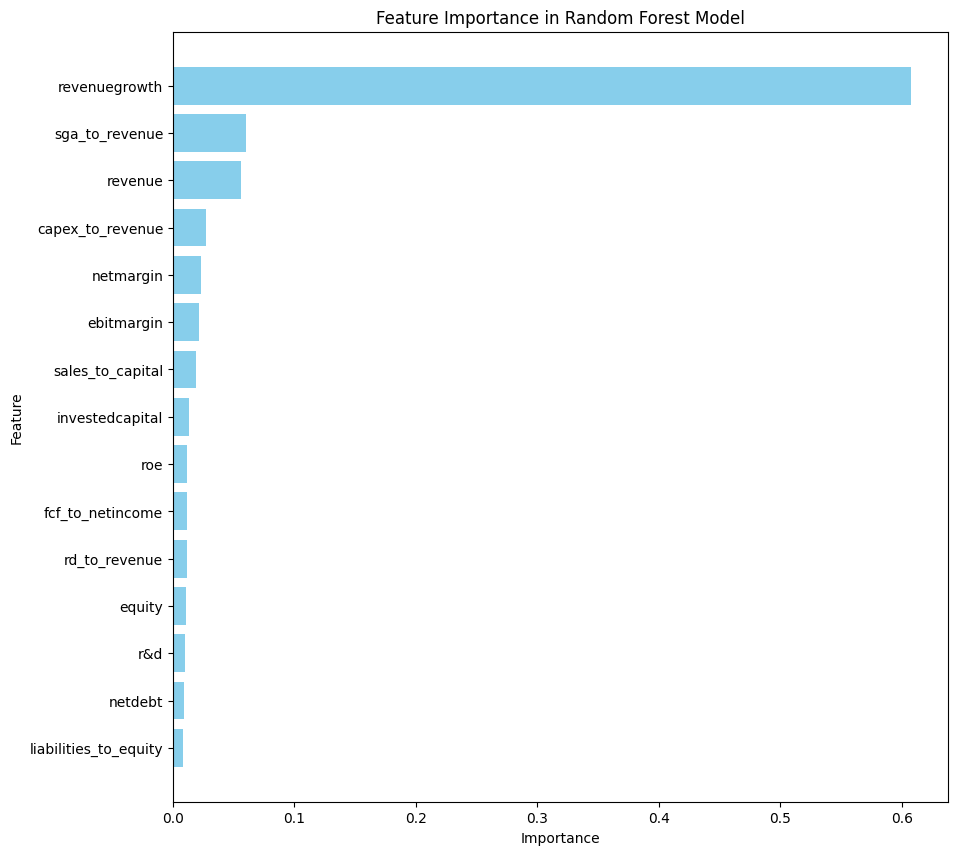

In [6]:
# Feature Importance for random forest
# rf_grid is a GridSearchCV object, and GridSearchCV itself doesn’t have .feature_importances_
# we need to get the best trained model from it and then extract the feature importances 
# from the RandomForestRegressor step inside the pipeline.
# the fitted Random Forest is at rf_grid.best_estimator_.named_steps["rf"].
rf_best = rf_grid.best_estimator_
importances = rf_best.named_steps["rf"].feature_importances_ # Retrieve feature importance from the random forest model
feature_importance = pd.DataFrame({
    "Feature": FeaturesNames,  # Feature names (columns)
    "Importance": importances  # Feature importance
}).sort_values(by="Importance", ascending=False).head(15)  # Sort features in descending order of importance

# Create a feature importance plot
plt.figure(figsize=(10, 10))  # Set the plot size to 10x10 inches
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="skyblue")  
# Draw a horizontal bar chart (barh) with feature importance
plt.xlabel("Importance")  # X-axis label
plt.ylabel("Feature")  # Y-axis label
plt.title("Feature Importance in Random Forest Model")  # Plot title
plt.gca().invert_yaxis()  # Invert the Y-axis so the most important features appear at the top
plt.show()  # Display the plot

In [13]:
# I am saving the model to pickle file

# Save
with open("random_forest_best.pkl", "wb") as f:
    pickle.dump(rf_grid.best_estimator_, f)

# Load
with open("random_forest_best.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Use
y_pred_loaded = loaded_model.predict(X_test)


In [ ]:

# 4) Feature importance — gain (how much a feature improves splits)

# For clarity, I access the underlying fitted XGBRegressor inside the pipeline.
# When we use an sklearn Pipeline, each step has a name 
# (here "xgb" was given when we defined the pipeline: ("xgb", XGBRegressor(...))).
# named_steps is a dictionary mapping step names -> the actual fitted objects.
# So xgb_best.named_steps["xgb"] pulls out the fitted XGBRegressor object from the pipeline.
# the functions like xgb.plot_importance require the raw model, not the whole pipeline

# The : xgb.XGBRegressor part is a type annotation.
# It says: "I expect xgb_fitted to be an object of type xgb.XGBRegressor".
# at runtime Python ignores type hints when running the code
# will run xgb_fitted = xgb_best.named_steps["xgb"]
xgb_fitted: xgb.XGBRegressor = xgb_best.named_steps["xgb"]

plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_fitted, max_num_features=20, importance_type="gain", height=0.6)
plt.title("Top 20 Feature Importances (XGBoost - Gain)")
plt.tight_layout()
plt.show()


In [55]:
# pip install -U xgboost

In [35]:
"""
Production-Style XGBoost Regression with early - stopping what will help me 

Goals
-----
1) Mirror the Random Forest setup (Pipeline, KFold CV, MAE scoring) for a fair comparison.
2) Use RandomizedSearchCV to explore hyperparameters efficiently.
3) Refit once with a **high n_estimators** and **early stopping** on a small
   validation slice of the *training* data to automatically pick the optimal
   number of boosting rounds.
4) Provide a consistent, honest evaluation on the *separate* test set using
   the `evaluate_regression`.

Why this flow?
--------------
- RandomizedSearchCV finds good regions of the XGBoost hyperparameter space faster
  than a big grid.
- Early stopping eliminates the guesswork on `n_estimators` and typically improves
  generalization while saving compute.
- Keeping preprocessing in a Pipeline ensures no leakage during CV.

"""

from typing import Dict
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

import xgboost as xgb

RANDOM_STATE = 42

# 1) Pipeline (median imputation + XGBoost regressor)
#    During search we keep n_estimators modest for speed; the final refit
#    will use a large cap with early stopping.

xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",   # fast & strong;
    n_estimators=800
)

xgb_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("xgb", xgb_base)
])

# 2) Randomized hyperparameter search
#    - MAE scoring (matches the RF)
#    - KFold with shuffling (same CV protocol)

param_dist = {
    "xgb__learning_rate":    [0.01, 0.03, 0.05, 0.1],
    "xgb__max_depth":        [3, 4, 5, 6, 7],
    "xgb__min_child_weight": [5, 10, 13, 15, 17, 20],
    "xgb__subsample":        [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__gamma":            [0.0, 0.1, 0.2],
    "xgb__reg_alpha":        [0.0, 0.1, 0.5, 1.0],
    "xgb__reg_lambda":       [1.0, 2.0, 5.0, 10.0],
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rand_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=50,                           # increase later to 48–64 for the precision, but it is much slowe
    scoring="neg_mean_absolute_error",   # apples-to-apples vs RF
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

rand_search.fit(X_train, y_train)
print("XGB (random search) best params:", rand_search.best_params_)
print("XGB (random search) best CV MAE:", -rand_search.best_score_)

best_pipe = rand_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGB (random search) best params: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 10.0, 'xgb__reg_alpha': 1.0, 'xgb__min_child_weight': 15, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.0, 'xgb__colsample_bytree': 0.6}
XGB (random search) best CV MAE: 0.11131655753009426


In [29]:
# 3) Training data prediction:
xgb_pred = rand_search.predict(X_train)                 # uses the refit best_estimator_
# or explicitly:
# xgb_best = rand_search.best_estimator_
# xgb_pred = xgb_best.predict(X_test)

print("XGB train:", evaluate_regression(y_train, xgb_pred))

XGB train: {'MAE': 0.08453438335290246, 'RMSE': 0.17790477307691216, 'MAPE_%': 130.0289903456283, 'R2': 0.6288246762258126}


In [30]:
# 4) Holdout prediction :
xgb_pred = rand_search.predict(X_test)                 # uses the refit best_estimator_
# or explicitly:
# xgb_best = rand_search.best_estimator_
# xgb_pred = xgb_best.predict(X_test)

print("XGB holdout:", evaluate_regression(y_test, xgb_pred))

XGB holdout: {'MAE': 0.09038193601926721, 'RMSE': 0.13340406910160557, 'MAPE_%': 155.30269033798035, 'R2': 0.6123750371214373}


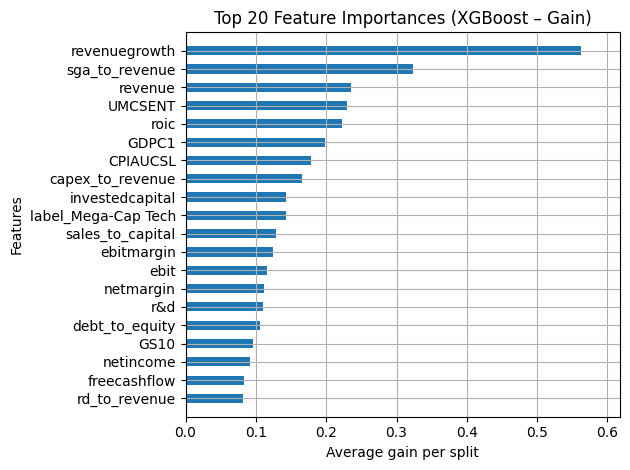

In [7]:
# 4) Feature importance — use the FITTED best estimator from the search
# Use the FITTED best estimator

xgb_best = rand_search.best_estimator_
fitted_xgb = xgb_best.named_steps["xgb"]
booster = fitted_xgb.get_booster()

# Attach the actual column names so xgboost stops using f0,f1,...
booster.feature_names = list(X_train.columns)

# the plot
ax = xgb.plot_importance(
    booster,
    importance_type="gain",
    max_num_features=20,
    height=0.5,
    show_values=False   # <- hide those long decimals
)
ax.set_title("Top 20 Feature Importances (XGBoost – Gain)")
ax.set_xlabel("Average gain per split")
ax.figure.tight_layout()
plt.show()

In [8]:
# SHAPP (step-by-step)

import shap

# Extract the fitted XGBoost model from the pipeline
best_pipe = rand_search.best_estimator_

# Get the imputer (same logic as in the pipeline)
imputer = best_pipe.named_steps["impute"]

# Apply imputation manually to training and test sets
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Extract the trained XGBRegressor
xgb_model = best_pipe.named_steps["xgb"]

# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_imputed, feature_names=FeaturesNames)

# Compute SHAP values for the test set
shap_values = explainer(X_test_imputed)

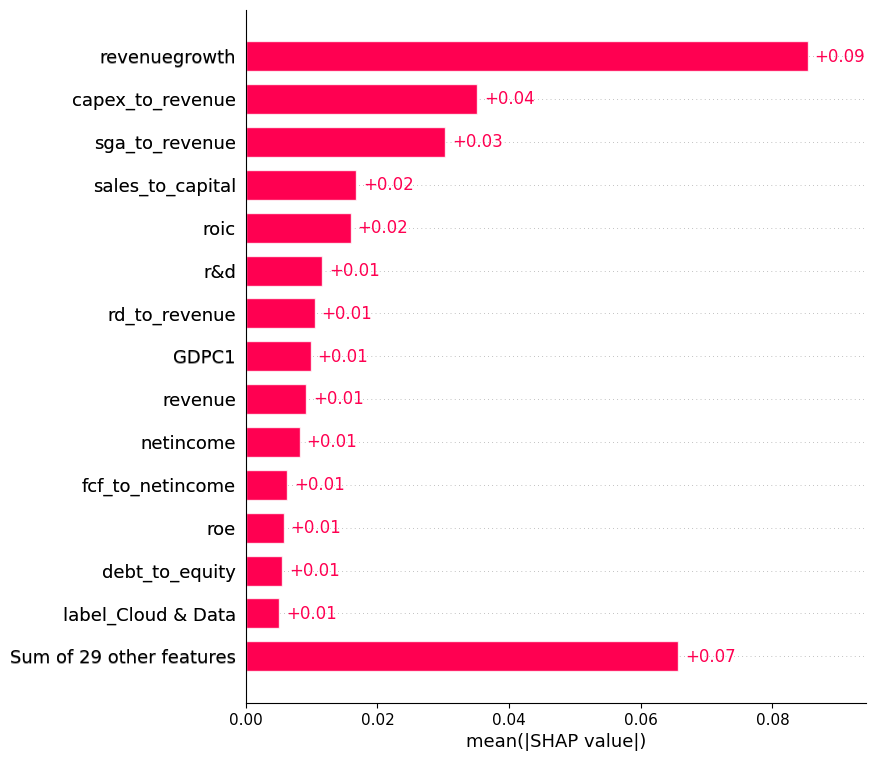

In [15]:
# Global feature importance (mean absolute SHAP value per feature)
shap.plots.bar(shap_values, max_display=15)

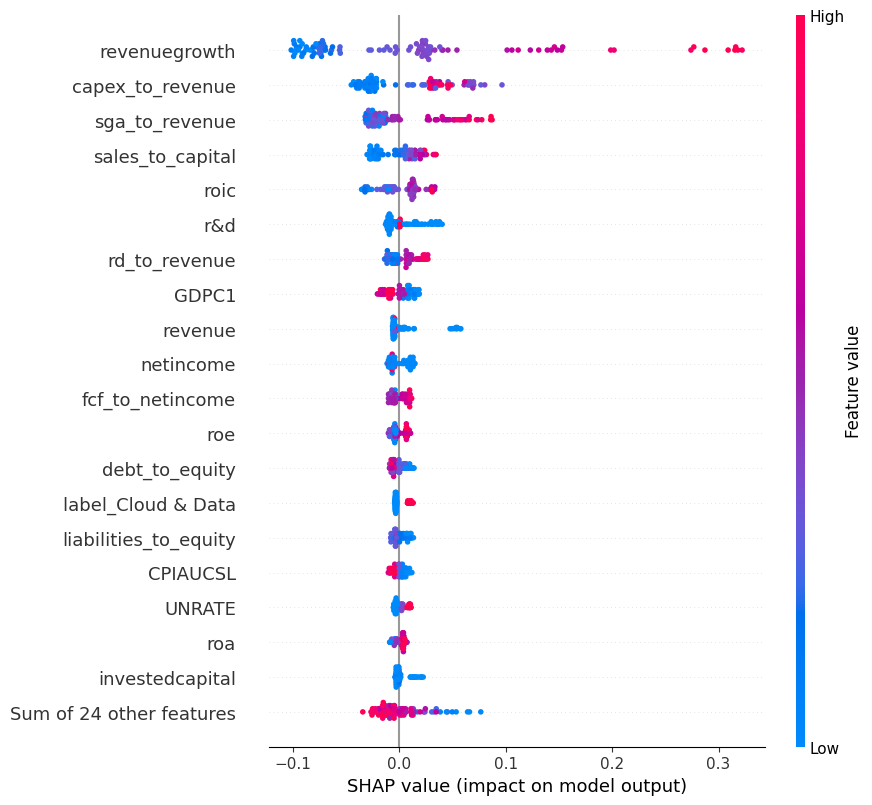

In [17]:
shap.plots.beeswarm(shap_values, max_display=20)

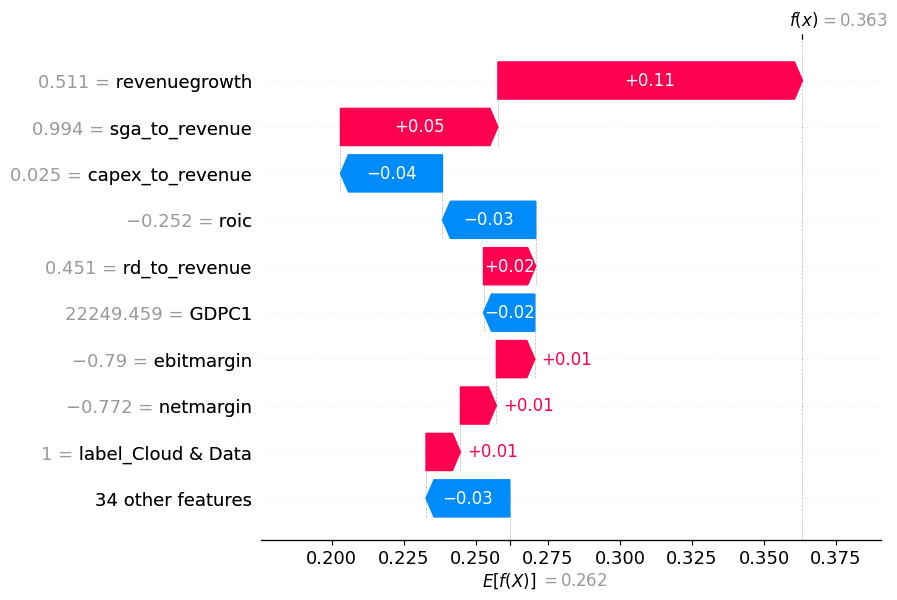

In [23]:
# Explain a single prediction
i = 0  # first test sample
shap.plots.waterfall(shap_values[i])

SHAP Analysis: Interpreting Feature Importance in XGBoost

The model's explainability analysis via SHAP consists of:
1. Global feature importance (mean absolute SHAP values);
2. Beeswarm plot (distribution of SHAP values for individual features);
3. Waterfall plot (local explanation for a single prediction).

1. Global Feature Importance – Bar Plot
- The most impactful feature on the model's prediction of next-year revenue growth (revenuegrowth_t+1) is current-year revenue growth. Its average SHAP value of +0.09 indicates it shifts predictions substantially across the dataset;
- Other strong predictors include:
  - capex_to_revenue (+0.04);
  - sga_to_revenue (+0.03);
  - sales_to_capital and roic (each +0.02).
- These ratios reflect a company's efficiency in using capital and controlling costs, which aligns with sound financial theory — companies reinvesting capital efficiently and controlling SG&A tend to grow faster.

The SHAP global importance plot confirms that historical revenue growth is the dominant predictor of future revenue growth. Investment efficiency (capex_to_revenue, sales_to_capital) and cost control (sga_to_revenue) also play key roles in shaping model predictions, echoing theoretical expectations of growth drivers in corporate finance.

2. SHAP Beeswarm Plot – Feature Impact Distribution
- This plot adds directional meaning to the bar plot;
- For instance:
  - High revenuegrowth values (in red) strongly increase the prediction;
  - High capex_to_revenue can increase or decrease predictions — suggesting a nonlinear relationship. Perhaps high capex signals investment (good) or inefficiency (bad), depending on context.

The SHAP beeswarm plot reveals the direction and dispersion of each feature's impact. Notably, high values of revenuegrowth (red) push predictions up, while features like capex_to_revenue have a mixed effect, potentially reflecting both productive investment and inefficient spending. This supports the case for incorporating non-linear ML models in forecasting.

3. Local Explanation – SHAP Waterfall Plot for One Firm (for one test example):
- Base value (model's average prediction): ~0.26;
- Final prediction: ~0.36
- Key positive drivers:
  - revenuegrowth: +0.11;
  - sga_to_revenue: +0.05;
- Key negative drivers:
  - capex_to_revenue: −0.04;
  - roic: −0.03

So, for this specific company, strong prior growth and low SG&A helped boost the forecast, while low ROIC and high capex spending dragged it down.

The SHAP waterfall plot provides a case-specific breakdown of the factors influencing the model’s prediction. For this firm, strong historical revenue growth and a lean SG&A cost structure were the most influential positive drivers. However, the model penalized the company for its relatively low Return on Invested Capital (ROIC) and high capital expenditures relative to revenue, which may indicate inefficient reinvestment or overextension. These financial characteristics reduced the forecasted revenue growth, offsetting some of the earlier positive signals.

Summary:

SHAP analysis offers crucial interpretability for our XGBoost model forecasting next-year revenue growth. At a global level, the model relies heavily on prior revenue growth, with significant contributions from capital efficiency metrics (e.g., capex_to_revenue, sales_to_capital) and cost structure (sga_to_revenue). The beeswarm plot highlights both the direction and scale of feature influence, confirming that the same feature can have varying effects depending on context — a strength of non-linear models. On a local level, waterfall plots provide a transparent breakdown of predictions, enabling case-by-case auditability. These insights validate both the economic logic embedded in the model and the practical interpretability of machine learning outputs.

Save and play

Now we want to save the final XGB Regressor model

Saving the rand_search.best_estimator_ is enough to save the full pipeline — including preprocessing (SimpleImputer) and XGBoost with all tuned parameters.

This object: rand_search.best_estimator_

is a Pipeline object, and it already contains:

- the imputer (SimpleImputer(strategy="median"))
- the best XGBoost regressor from the RandomizedSearchCV, with all best-found hyperparameters.

The above alsi works for STandardScalar: If the pipeline uses scaling (like StandardScaler() for linear models), we should still save the pipeline the same way. Everything inside the Pipeline gets serialized safely.

In [38]:
# I am saving the model to pickle file

# Save
with open("XGBRegressor_best.pkl", "wb") as f:
    pickle.dump(rand_search.best_estimator_, f)

# Load
with open("XGBRegressor_best.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Verify
y_pred_loaded = loaded_model.predict(X_test)

rmse_l = mean_squared_error(y_test, y_pred_loaded)
mae_l = mean_absolute_error(y_test, y_pred_loaded)
r2_l = r2_score(y_test, y_pred_loaded)
print(f"After loading — RMSE: {rmse_l:.4f} | MAE: {mae_l:.4f} | R²: {r2_l:.4f}")

After loading — RMSE: 0.0178 | MAE: 0.0904 | R²: 0.6124


In [45]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.5 MB 1.9 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
"""
Production-Style LightGBM Regression (fast randomized search + early stopping)

Why this is practical
---------------------
1) RandomizedSearchCV explores the key bias/variance knobs quickly (minutes, not hours).
2) We keep n_estimators modest during search; the final refit uses a high cap + early stopping
   to pick the optimal number automatically.
3) MAE scoring and the same KFold CV keep results comparable to the RF/XGB runs.

Notes
-----
- LightGBM handles NaNs natively. We keep median imputation to mirror the RF/XGB pipelines.
  There is a possibility to drop the imputer for LGBM and let it handle missing values.
- Avoid double parallelism: when RandomizedSearchCV uses n_jobs=-1, set LGBM's n_jobs=1.
"""

from typing import Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb


RANDOM_STATE = 42

# ---------------------------------------------------------------------------
# 1) Pipeline (median imputation + LightGBM)
#    Keep n_estimators modest during search; early stopping will be used later.
# ---------------------------------------------------------------------------
lgb_base = lgb.LGBMRegressor(
    boosting_type="gbdt",
    n_estimators=800,         # modest for search; we'll raise it for the final ES refit
    learning_rate=0.05,       # will be tuned
    subsample_freq=1,         # enable row sampling when subsample<1
    n_jobs=1,                 # avoid thread thrash with CV parallelism
    random_state=RANDOM_STATE
)

lgb_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("lgb", lgb_base)
])

# ---------------------------------------------------------------------------
# 2) Randomized hyperparameter search (fast)
#    MAE scoring to match the other models; 5-fold CV for fairness.
# ---------------------------------------------------------------------------
param_dist = {
    "lgb__learning_rate":     [0.01, 0.03, 0.05, 0.1],
    'lgb__n_estimators':      [100, 200],
    "lgb__num_leaves":        [15, 31, 63, 127],   # capacity; interacts with max_depth
    "lgb__max_depth":         [3, 5, 7, -1],       # -1 = no limit
    "lgb__min_child_samples": [5, 10, 20, 50],     # like min samples per leaf
    "lgb__subsample":         [0.6, 0.8, 1.0],     # row sampling
    "lgb__colsample_bytree":  [0.6, 0.8, 1.0],     # feature sampling
    "lgb__reg_alpha":         [0.0, 0.1, 0.5, 1.0],# L1
    "lgb__reg_lambda":        [0.0, 0.1, 0.5, 1.0] # L2
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lgb_search = RandomizedSearchCV(
    estimator=lgb_pipe,
    param_distributions=param_dist,
    n_iter=32,                          # bump to 48–64 if we can afford it
    scoring="neg_mean_absolute_error",  # apples-to-apples with RF/XGB
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

lgb_search.fit(
    X_train, 
    y_train, 
    lgb__feature_name=X_train.columns.tolist()  # <- THIS is the key)
    )
print("LGBM best params:", lgb_search.best_params_)
print("LGBM best CV MAE:", -lgb_search.best_score_)

# ---------------------------------------------------------------------------
# 3) Honest holdout evaluation (search refit)
# ---------------------------------------------------------------------------
lgb_pred_cvrefit = lgb_search.predict(X_test)
print("LGBM (CV-refit) holdout:", evaluate_regression(y_test, lgb_pred_cvrefit))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3849
[LightGBM] [Info] Number of data points in the train set: 395, number of used features: 43
[LightGBM] [Info] Start training from score 0.268358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

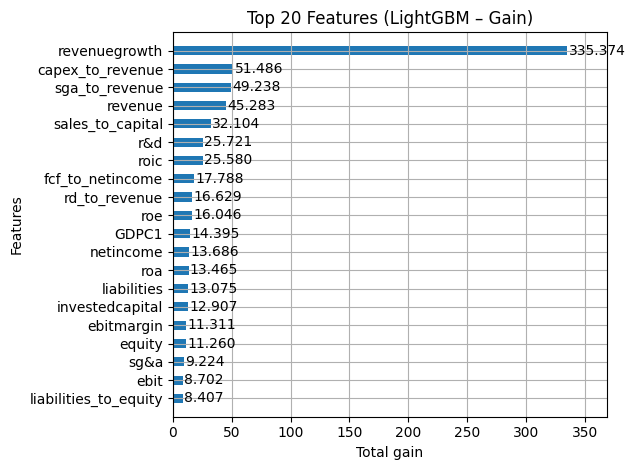

In [36]:
# 4) Feature importance — use the FITTED best estimator from the search
# Use the FITTED best estimator from the search
lgb_best = lgb_search.best_estimator_
fitted_lgb = lgb_best.named_steps["lgb"]      # LGBMRegressor
booster = fitted_lgb.booster_                 # LightGBM Booster

# Direct plot with correct feature names
# because I passed lgb__feature_name=X_train.columns.tolist() when fitting, 
# the plot will automatically show the real feature names — no need to manually set booster.feature_name

ax = lgb.plot_importance(
    booster,
    importance_type="gain",
    max_num_features=20,
    height=0.5,
    
)
ax.set_title("Top 20 Features (LightGBM – Gain)")
ax.set_xlabel("Total gain")
ax.figure.tight_layout()
plt.show()

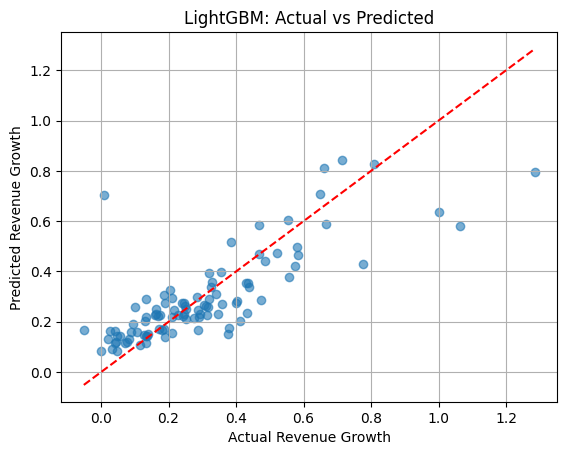

In [48]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Revenue Growth")
plt.ylabel("Predicted Revenue Growth")
plt.title("LightGBM: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.grid()
plt.show()

In [49]:
# Predict on train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Compute R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R²: {r2_train:.4f}")
print(f"Test  R²: {r2_test:.4f}")
print(f"Gap (Train - Test): {r2_train - r2_test:.4f}")

Train R²: 0.5755
Test  R²: 0.6341
Gap (Train - Test): -0.0586


What This Means:
- model is not overfitting — quite the opposite;
- The slightly better test R² could be due to:
  - Some regularization effects (like reg_lambda, reg_alpha;
  - Random variation in folds (the train/test split might have favorable noise characteristics);
  - LightGBM's boosting structure optimizing generalization naturally

Conclusion:
- No signs of overfitting. The LightGBM model generalizes very well.

In [44]:
companies_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 349 to 379
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   revenue                 395 non-null    float64
 1   netincome               395 non-null    float64
 2   r&d                     395 non-null    float64
 3   sg&a                    395 non-null    float64
 4   ebit                    395 non-null    float64
 5   revenuegrowth           395 non-null    float64
 6   ebitmargin              395 non-null    float64
 7   netmargin               395 non-null    float64
 8   rd_to_revenue           395 non-null    float64
 9   sga_to_revenue          395 non-null    float64
 10  operatingcashflow       395 non-null    float64
 11  capex                   395 non-null    float64
 12  assets                  395 non-null    float64
 13  equity                  395 non-null    float64
 14  totaldebt               395 non-null    float

In [50]:
# Let's use selected features from Notebook No. 4


numeric_cols = ['revenuegrowth', 'sga_to_revenue', 'ebitmargin', 'rd_to_revenue', 'CPIAUCSL', 'GDPC1', 'liabilities']

cat_vars = [col for col in companies_train_encoded.columns if col.startswith("label_")]

selected_vars = numeric_cols + cat_vars

selected_vars 

['revenuegrowth',
 'sga_to_revenue',
 'ebitmargin',
 'rd_to_revenue',
 'CPIAUCSL',
 'GDPC1',
 'liabilities',
 'label_Cloud & Data',
 'label_Collab & CX SaaS',
 'label_Consumer SaaS',
 'label_Enterprise SaaS',
 'label_Mature Pivots',
 'label_Mega‑Cap Tech',
 'label_Vertical SaaS']

In [51]:
# Define model input/output
X_train_sel = companies_train_encoded[selected_vars]
X_test_sel = companies_test_encoded[selected_vars]
y_train_sel = companies_train_encoded["revenuegrowth_t+1"]
y_test_sel = companies_test_encoded["revenuegrowth_t+1"]

In [52]:
model =  DecisionTreeRegressor(max_depth=3) # how many nodes)

# trenujemy model
model.fit(X_train_sel, y_train_sel)

DecisionTreeRegressor(max_depth=3)

In [53]:
y_pred_sel = model.predict(X_test_sel)

r2 = r2_score(y_test_sel, y_pred_sel)
print(f"R² Score: {r2:.4f}")

R² Score: -0.9083


In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_train_sel, y_train_sel)
y_pred_sel = model.predict(X_test_sel)

In [55]:
r2 = r2_score(y_test_sel, y_pred_sel)
print(f"R² Score: {r2:.4f}")

R² Score: -0.0663


In [56]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 100, 200]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train_sel, y_train_sel)

print("Best params:", grid.best_params_)

Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


In [57]:
# Step 1: Access the best model found by GridSearchCV
best_rf_model = grid.best_estimator_

# Step 2: Make predictions on the test set
y_pred = best_rf_model.predict(X_test_sel)

# Step 3: Evaluate performance
mae = mean_absolute_error(y_test_sel, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_sel, y_pred))
r2 = r2_score(y_test_sel, y_pred)

print("\nEvaluation of Best Random Forest Model:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")


Evaluation of Best Random Forest Model:
MAE : 0.1085
RMSE: 0.2067
R²  : 0.0698
